<a href="https://colab.research.google.com/github/lacykaltgr/quant/blob/main/quant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Setup

In [2]:
import pandas as pd
import numpy as np

In [3]:
quant_folder_location = "/content/drive/MyDrive/quant"
weather_prepared_file_path = quant_folder_location + "/weather_df.csv"
county_location_file_path = quant_folder_location + "/agri/minnesota_county_location.csv"
county_agr_prod_file_path = quant_folder_location + "/agri/minnesota_county_yearly_agricultural_production.csv"
station_location_file_path = quant_folder_location + "/weather/minnesota_station_location.csv"

def station_weather_fp(station_name):
  return quant_folder_location + "/weather/minnesota_daily/" + str(station_name) + ".csv"

# Prepare weather data


In [5]:
#átugrási lehetőség
weather_df = pd.read_csv(weather_prepared_file_path)

<ipython-input-5-b90705cc2f0b>:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  weather_df = pd.read_csv(weather_prepared_file_path)


In [7]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 603227 entries, 0 to 603226
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  603227 non-null  int64  
 1   date        603227 non-null  object 
 2   avg         603227 non-null  float64
 3   min         603227 non-null  float64
 4   max         603227 non-null  float64
 5   rain        603227 non-null  float64
 6   code        603227 non-null  object 
 7   lat         603227 non-null  float64
 8   lon         603227 non-null  float64
dtypes: float64(6), int64(1), object(2)
memory usage: 41.4+ MB


In [10]:
station_location_df = pd.read_csv(station_location_file_path)
station_weather_df_list = []
station_codes = np.unique(station_location_df.Code)
for code in station_codes:
  try:
      station_df = pd.read_csv(station_weather_fp(code), header=None, index_col=False, names=["date", "avg", "min", "max", "rain"])
      station_weather_df_list.append(station_df)
  except:
      station_codes.remove(code)
      print(f"Hibás/üres fájl: {code}")

In [16]:
from dateutil.relativedelta import relativedelta
import math

for station in station_weather_df_list:
  station["date"] = pd.to_datetime(station["date"])
  station["min"] = station["min"].interpolate(method="linear", limit=21)
  station["max"] = station["max"].interpolate(method="linear", limit=21)
  for index, record in station.iterrows():
    if math.isnan(record["min"]):
      for i in range(index, index+15*365+1, 365):
        if not math.isnan(station.iloc[i+365]["min"]):
          station.loc[index, "min"] = station.iloc[i+365]["min"]
          break
        else: 
          if not math.isnan(station.iloc[i-365]["min"]):
            station.loc[index, "min"] = station.iloc[i-365]["min"]
            break
    if math.isnan(record["max"]):
      for i in range(index, index+15*365+1, 365):
        if not math.isnan(station.iloc[i+365]["max"]):
          station.loc[index, "max"] = station.iloc[i+365]["max"]
          break
        else:
          if not math.isnan(station.iloc[i-365]["max"]):
            station.loc[index, "max"] = station.iloc[i-365]["max"]
            break
    if math.isnan(record["rain"]):
      i = index+365
      while i < len(station):
        if not math.isnan(station.iloc[i]["rain"]):
          station.loc[index, "rain"] = station.iloc[i]["rain"]
          break
        i += 365

KeyboardInterrupt: ignored

In [ ]:
for i, (station_data, code) in enumerate(zip(station_weather_df_list, station_codes)):
  lat = station_location_df[station_location_df["Code"] == code ].Latitude.values[0]
  lon = station_location_df[station_location_df["Code"] == code ].Longitude.values[0]
  station_weather_df_list[i] = station_data.assign(code = code, lat = lat, lon = lon)

combined_weather_df = pd.concat(station_weather_df_list, axis=0)

In [ ]:
combined_weather_df["rain"] = combined_weather_df["rain"].fillna(0)

In [ ]:
combined_weather_df.info()

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBRegressor

no_missing_weather_df = combined_weather_df[combined_weather_df["avg"].notnull()]
no_missing_weather_train_df = no_missing_weather_df.drop(["code", "rain"], axis=1)
no_missing_weather_train_df['year'] = no_missing_weather_train_df['date'].dt.year
no_missing_weather_train_df['month'] = no_missing_weather_train_df['date'].dt.month
no_missing_weather_train_df['day'] = no_missing_weather_train_df['date'].dt.day
no_missing_weather_train_df = no_missing_weather_train_df.drop("date", axis=1)

X_fill_avg = no_missing_weather_train_df.drop("avg", axis=1)
y_fill_avg = no_missing_weather_train_df["avg"]
X_avg_train, X_avg_test, y_avg_train, y_avg_test = train_test_split(X_fill_avg, y_fill_avg, test_size=0.1)
evaluation = [(X_avg_train, y_avg_train), (X_avg_test, y_avg_test)]

model = XGBRegressor(early_stopping_rounds=300)
model.fit(X_avg_train, y_avg_train, eval_set=evaluation, verbose=1)

In [ ]:
missing_avg_weather_df = combined_weather_df[combined_weather_df["avg"].isnull()]
missing_avg_weather_prediction_X_df = missing_avg_weather_df.drop(["avg", "code", "rain"], axis=1)
missing_avg_weather_prediction_X_df['year'] = missing_avg_weather_prediction_X_df['date'].dt.year
missing_avg_weather_prediction_X_df['month'] = missing_avg_weather_prediction_X_df['date'].dt.month
missing_avg_weather_prediction_X_df['day'] = missing_avg_weather_prediction_X_df['date'].dt.day
missing_avg_weather_prediction_X_df = missing_avg_weather_prediction_X_df.drop("date", axis=1)

missing_avg_weather_prediction_y_df = model.predict(missing_avg_weather_prediction_X_df)
missing_avg_weather_df["avg"] = missing_avg_weather_prediction_y_df

In [ ]:
missing_avg_weather_df.info()

In [ ]:
weather_df = pd.concat([missing_avg_weather_df, no_missing_weather_df], axis=0)

In [8]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 603227 entries, 0 to 603226
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  603227 non-null  int64  
 1   date        603227 non-null  object 
 2   avg         603227 non-null  float64
 3   min         603227 non-null  float64
 4   max         603227 non-null  float64
 5   rain        603227 non-null  float64
 6   code        603227 non-null  object 
 7   lat         603227 non-null  float64
 8   lon         603227 non-null  float64
dtypes: float64(6), int64(1), object(2)
memory usage: 41.4+ MB


In [ ]:
filename = 'weather_df.csv'
weather_df.to_csv('/content/drive/MyDrive/quant' + filename)

In [13]:
weather_stations = []
for code in station_codes:
  station = dict()
  station["code"] = code
  station["lat"] = station_location_df[station_location_df["Code"] == code]["Latitude"].values[0]
  station["lon"] = station_location_df[station_location_df["Code"] == code]["Longitude"].values[0]

  weather_data = weather_df[weather_df['code'] == code].drop(["code", "Unnamed: 0", "lat", "lon"], axis=1)
  station["weather_daily"] = weather_data

  weather_data["date"] = pd.to_datetime(weather_data["date"])
  weather_data["year"] = weather_data['date'].dt.year
  weather_data['week'] = weather_data['date'].dt.isocalendar().week
  weather_data = weather_data.drop("date", axis=1)
  weekly_stats = weather_data.groupby(['year', 'week']).agg({'min': ['mean', 'std'], 'max': ['mean', 'std'], 'avg': ['mean', 'std'], 'rain': ['mean', 'std']})
  weekly_stats = weekly_stats.reset_index()
  weekly_stats.columns = ['year', 'week', 'min_mean', 'min_std', 'max_mean', 'max_std', 'avg_mean', 'avg_std', 'rain_mean', 'rain_std']
  weekly_stats = weekly_stats.fillna(0)
  station["weather_weekly"] = weekly_stats
  weather_stations.append(station)
len(weather_stations)

97

In [14]:
weather_stations[0]["weather_weekly"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2588 entries, 0 to 2587
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   year       2588 non-null   int64  
 1   week       2588 non-null   UInt32 
 2   min_mean   2588 non-null   float64
 3   min_std    2588 non-null   float64
 4   max_mean   2588 non-null   float64
 5   max_std    2588 non-null   float64
 6   avg_mean   2588 non-null   float64
 7   avg_std    2588 non-null   float64
 8   rain_mean  2588 non-null   float64
 9   rain_std   2588 non-null   float64
dtypes: UInt32(1), float64(8), int64(1)
memory usage: 194.7 KB


# Prepare crop data

In [15]:
county_locations_df = pd.read_csv(county_location_file_path)
county_agr_prod_df = pd.read_csv(county_agr_prod_file_path, decimal=',')

In [16]:
county_agr_prod_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56268 entries, 0 to 56267
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Year                          56268 non-null  int64 
 1   County                        56268 non-null  object
 2   Commodity                     56268 non-null  object
 3   Crop                          56268 non-null  object
 4   ACRES HARVESTED               52674 non-null  object
 5   PRODUCTION, MEASURED IN BU    33231 non-null  object
 6   YIELD, MEASURED IN BU / ACRE  33232 non-null  object
dtypes: int64(1), object(6)
memory usage: 3.0+ MB


In [17]:
county_agr_prod_df = county_agr_prod_df.rename(
    columns={'ACRES HARVESTED': 'acres', 
             'PRODUCTION, MEASURED IN BU': 'production', 
             'YIELD, MEASURED IN BU / ACRE': 'yield'})
county_agr_prod_df['acres'] = pd.to_numeric(county_agr_prod_df['acres'].astype(str).str.replace(',', '.'), errors='coerce')
county_agr_prod_df['production'] = pd.to_numeric(county_agr_prod_df['production'].astype(str).str.replace(',', '.'), errors='coerce')
county_agr_prod_df['yield'] = pd.to_numeric(county_agr_prod_df['yield'].astype(str).str.replace(',', '.'), errors='coerce')
county_agr_prod_df = county_agr_prod_df[county_agr_prod_df['acres'].notnull() | county_agr_prod_df['production'].notnull() | county_agr_prod_df['yield'].notnull()]

corn_df = county_agr_prod_df[county_agr_prod_df["Crop"] == "CORN, GRAIN"] #| county_agr_prod_df["Crop"] == "CORN, SILAGE"]
oat_df = county_agr_prod_df[county_agr_prod_df["Crop"] == "OATS"]
soybean_df = county_agr_prod_df[county_agr_prod_df["Crop"] == "SOYBEANS"]

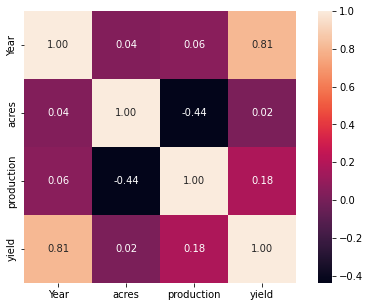

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plot = corn_df

plot = plot[plot['acres'].notnull() & plot['production'].notnull() & plot['yield'].notnull()]
numeric_columns = plot.select_dtypes(include=['int64', 'float64']).columns

cm = np.corrcoef(plot[numeric_columns].values.T)
fig = plt.gcf()
fig.set_size_inches(8, 5)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=numeric_columns.values, xticklabels=numeric_columns.values)

In [19]:
county_locations_df['county_name'] = county_locations_df['county_name'].apply(lambda x: ' '.join(x.split()[:-1]).upper())
county_locations_df['county_name'] = county_locations_df['county_name'].str.replace('SAINT LOUIS', 'ST. LOUIS')
corn_df_extended = pd.merge(corn_df, county_locations_df, how='outer', left_on='County', right_on='county_name')

In [20]:
corn_df_clean = corn_df_extended.drop(["County", "Commodity", "Crop", "county_name", "capital_name", "production", "acres"], axis=1)
corn_df_clean = corn_df_clean[corn_df_clean["yield"].notnull() & corn_df_clean["county_latitude"].notnull() & corn_df_clean["county_longitude"].notnull()]

#putting it all together...

In [21]:
corn_df_clean.info() #corn clean df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5014 entries, 0 to 5014
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Year              5014 non-null   float64
 1   yield             5014 non-null   float64
 2   county_latitude   5014 non-null   float64
 3   county_longitude  5014 non-null   float64
dtypes: float64(4)
memory usage: 195.9 KB


In [22]:
weather_stations[0] #weather clean df

{'code': '72644',
 'lat': 43.9,
 'lon': -92.5,
 'weather_daily':              date   avg   min   max  rain  year  week
 95927  1973-01-01 -12.2 -16.1  -8.9   0.0  1973     1
 95928  1973-01-02  -6.3 -13.9  -0.6   0.0  1973     1
 95929  1973-01-03  -3.6 -12.2  -1.7  19.6  1973     1
 95930  1973-01-04 -18.7 -22.8 -12.2   0.0  1973     1
 95931  1973-01-05 -23.9 -27.8 -19.4   0.0  1973     1
 ...           ...   ...   ...   ...   ...   ...   ...
 113541 2022-06-13  20.7  18.0  25.0  22.5  2022    24
 113542 2022-06-14  27.9  22.0  35.0   0.0  2022    24
 113543 2022-06-15  19.7  17.2  24.4  19.3  2022    24
 113544 2022-06-16  22.5  17.4  27.3   0.0  2022    24
 113545 2022-06-17  20.4  15.4  25.4   0.0  2022    24
 
 [17619 rows x 7 columns],
 'weather_weekly':       year  week   min_mean   min_std   max_mean   max_std   avg_mean  \
 0     1973     1 -22.637500  7.546984 -12.837500  8.395056 -17.362500   
 1     1973     2 -20.371429  7.452229 -10.000000  7.626926 -14.942857   
 2     

In [46]:
from math import radians, sin, cos, sqrt, atan2

def distance(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km

    # Convert latitude and longitude to radians
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    # Calculate the differences between the two points
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Calculate the haversine of half the differences
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2

    # Calculate the great circle distance
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    # Calculate the distance in kilometers
    dist = R * c

    return dist


def distance_from_station(weather_station, lat, lon):
  return distance(weather_station["lat"], weather_station["lon"], lat, lon)


In [45]:
weather_staions = filter(lambda x: not x["weather_weekly"].empty, weather_stations)

In [64]:
data = []
for _, y in corn_df_clean.iterrows():
  yearly_data = dict()
  yearly_data["year"] = y["Year"]
  yearly_data["yield"] = y["yield"]
  county_lat = y["county_latitude"]
  county_lon = y["county_longitude"]
  stations = sorted(weather_stations, key=lambda s:distance_from_station(s, county_lat, county_lon))

  i = 0
  while distance_from_station(stations[i], county_lat, county_lon) < 120:
    station_weekly = stations[i]["weather_weekly"]
    yearly_data["weather"] = station_weekly[station_weekly["year"] == y["Year"]]
    yearly_data["weather"] = yearly_data["weather"].drop(["year", "week"], axis=1)
    if not yearly_data['weather'].empty:
      data.append(yearly_data)
      break
    i += 1
  
len(data)

2860

In [54]:
#valid_adatok = []
#for tav in range(10, 200, 5):
#  data = []
#  for _, y in corn_df_clean.iterrows():
#    yearly_data = dict()
#    yearly_data["year"] = y["Year"]
#    yearly_data["yield"] = y["yield"]
#    county_lat = y["county_latitude"]
#    county_lon = y["county_longitude"]
#    stations = sorted(weather_stations, key=lambda s:distance_from_station(s, county_lat, county_lon))
#
#    i = 0
#    while distance_from_station(stations[i], county_lat, county_lon) < tav:
#      station_weekly = stations[i]["weather_weekly"]
#      yearly_data["weather"] = station_weekly[station_weekly["year"] == y["Year"]]
#      if not yearly_data['weather'].empty:
#        data.append(yearly_data)
#        break
#      i += 1
    
#  valid_adatok.append(len(data))

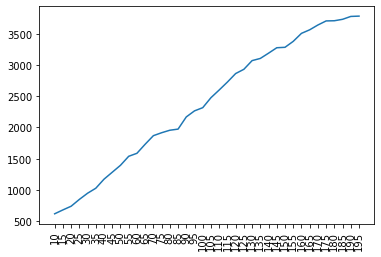

In [59]:
import matplotlib.pyplot as plt
x_values = [10+x*5 for x in range(len(valid_adatok))]
plt.xticks(range(len(valid_adatok)), x_values, rotation=90)
plt.plot(valid_adatok)

In [66]:
X_weather = list(map(lambda s: s["weather"], data))
X_year = list(map(lambda s: s["year"], data))
y = list(map(lambda s: s["yield"], data))

In [67]:
split_ratio = 0.9
split = int(len(data)*split_ratio)
X_weather_train = X_weather[:split]
X_weather_val = X_weather[split:]
X_year_train = X_year[:split]
X_year_val = X_year[split:]
y_train = y[:split]
y_val = y[split:]

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, Concatenate
from tensorflow.keras.models import Model


seq_input = Input(shape=(52, 5))
int_input = Input(shape=(1,))


lstm1 = LSTM(128, return_sequences=True)(seq_input)
drop1 = Dropout(0.2)(lstm1)
lstm2 = LSTM(64, return_sequences=False)(drop1)
drop2 = Dropout(0.2)(lstm2)

concat = Concatenate()([drop2, int_input])

dense1 = Dense(32, activation='relu')(concat)
dense2 = Dense(1, activation='linear')(dense1)

model = Model(inputs=[seq_input, int_input], outputs=dense2)

model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model.fit([X_weather_train, X_year_train], y_train, epochs=100, batch_size=32)

In [ ]:
loss = model.evaluate([X_weather_, int_test], y_test)
print('Test loss:', loss)

In [ ]:
y_pred = model.predict([X_new, int_new])